# Wikidata evaluation

Evaluate the EKE methodology w.r.t the baseline (i.e TF-IDF)

## Define filepaths

In [1]:
root_dir = '../..'
data_dir = 'data'
corpus_dir = 'corpus'
rank_dir = 'terms'

In [2]:
version = 'v2'

## Load ground truth

Load each dataset

In [3]:
import os
import pandas as pd

In [4]:
wikidata_dir = 'cities_wikidata'

In [5]:
datasets_df = []

for filename in os.listdir(os.path.join(root_dir, data_dir, corpus_dir, wikidata_dir)):
    filepath = os.path.join(root_dir, data_dir, corpus_dir, wikidata_dir, filename)
    entry_df = pd.read_excel(filepath, index_col=0)
    datasets_df.append(entry_df)

len(datasets_df)

329

Merge all datasets into a single DataFrame

In [6]:
df = pd.concat(datasets_df, axis=0, ignore_index=True)
df = df[['entity', 'target']].drop_duplicates()
df.head()

,entity,target
0,Q42053,"Isfahan (City in Iran, Isfahan province, cente..."
17,Q1367759,Isfahan Province (Province of Iran)
18,Q25433162,Isfahan (electoral district in Iran)
30,Q21998562,Isfahan (1967 jazz song by Duke Ellington)
45,Q1282082,"Isfahan County (county in Isfahan, Iran)"


In [7]:
gt_dict = pd.Series(df['target'].values,index=df['entity']).to_dict()

In [8]:
del datasets_df
del df

## Load rankings

### LIME-based

In [9]:
lime_filename = f'ranking_wikidata_nn_tfidf_{version}.xlsx'
lime_filepath = os.path.join(root_dir, data_dir, rank_dir, lime_filename)

In [10]:
lime_df = pd.read_excel(lime_filepath, index_col=0)
# Replace '_' character with whitespaces
lime_df['term'] = lime_df['term'].map(lambda x: x.replace('_', ' '))
lime_df.head()

,label,term,weight
0,Q1005682,carver,3.252445
1,Q1005682,hamburg,2.680185
2,Q1005682,minnesota,2.503608
3,Q1005682,states,0.913663
4,Q1005682,513,0.877568


In [11]:
lime_df.shape

(4712, 3)

### Baseline

In [12]:
baseline_filename = f'ranking_wikidata_baseline_{version}.xlsx'
baseline_filepath = os.path.join(root_dir, data_dir, rank_dir, baseline_filename)

In [13]:
baseline_df = pd.read_excel(baseline_filepath, index_col=0)
# Replace '_' character with whitespaces
baseline_df['term'] = baseline_df['term'].map(lambda x: x.replace('_', ' '))
baseline_df.head()

,label,term
0,Q1754,stockholm
1,Q1754,sthlm
2,Q1754,city
3,Q1754,sweden
4,Q1754,capital


In [14]:
baseline_df.shape

(895050, 2)

## Compute metrics for LIME and the baseline

In [15]:
src_dir = 'src'

In [16]:
import sys
sys.path.append(os.path.join(root_dir, src_dir))

In [17]:
lime_metrics_list = []
baseline_metrics_list = []

In [18]:
grouped_lime_df = lime_df.groupby('label')
grouped_baseline_df = baseline_df.groupby('label')

In [19]:
from metrics import compute_metrics

In [20]:
for group_name, group_data in grouped_lime_df:
    lime_terms = group_data['term'].values
    lime_metrics = compute_metrics(group_name, gt_dict, lime_terms)
    lime_metrics_list.append(lime_metrics)
    
    baseline_terms = grouped_baseline_df.get_group(group_name)['term']
    baseline_terms = baseline_terms.values
    baseline_metrics = compute_metrics(group_name, gt_dict, baseline_terms)
    baseline_metrics_list.append(baseline_metrics)

## Plot metrics

In [21]:
from plot import compare_boxplots, compare_lineplots, show_barplot

In [22]:
use_plotly = False

if not use_plotly:
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

**Metric #1**: minimum value of `k` s.t `recall[k] > threshold` where `threshold = 0.9`

In [23]:
lime_k_recall = [entry['k_recall'] for entry in lime_metrics_list if entry['k_recall'] is not None]
baseline_k_recall = [entry['k_recall'] for entry in baseline_metrics_list if entry['k_recall'] is not None]

In [24]:
print(f'lime_k_recall size: {len(lime_k_recall)}')
print(f'baseline_k_recall size: {len(baseline_k_recall)}')

lime_k_recall size: 86
baseline_k_recall size: 132


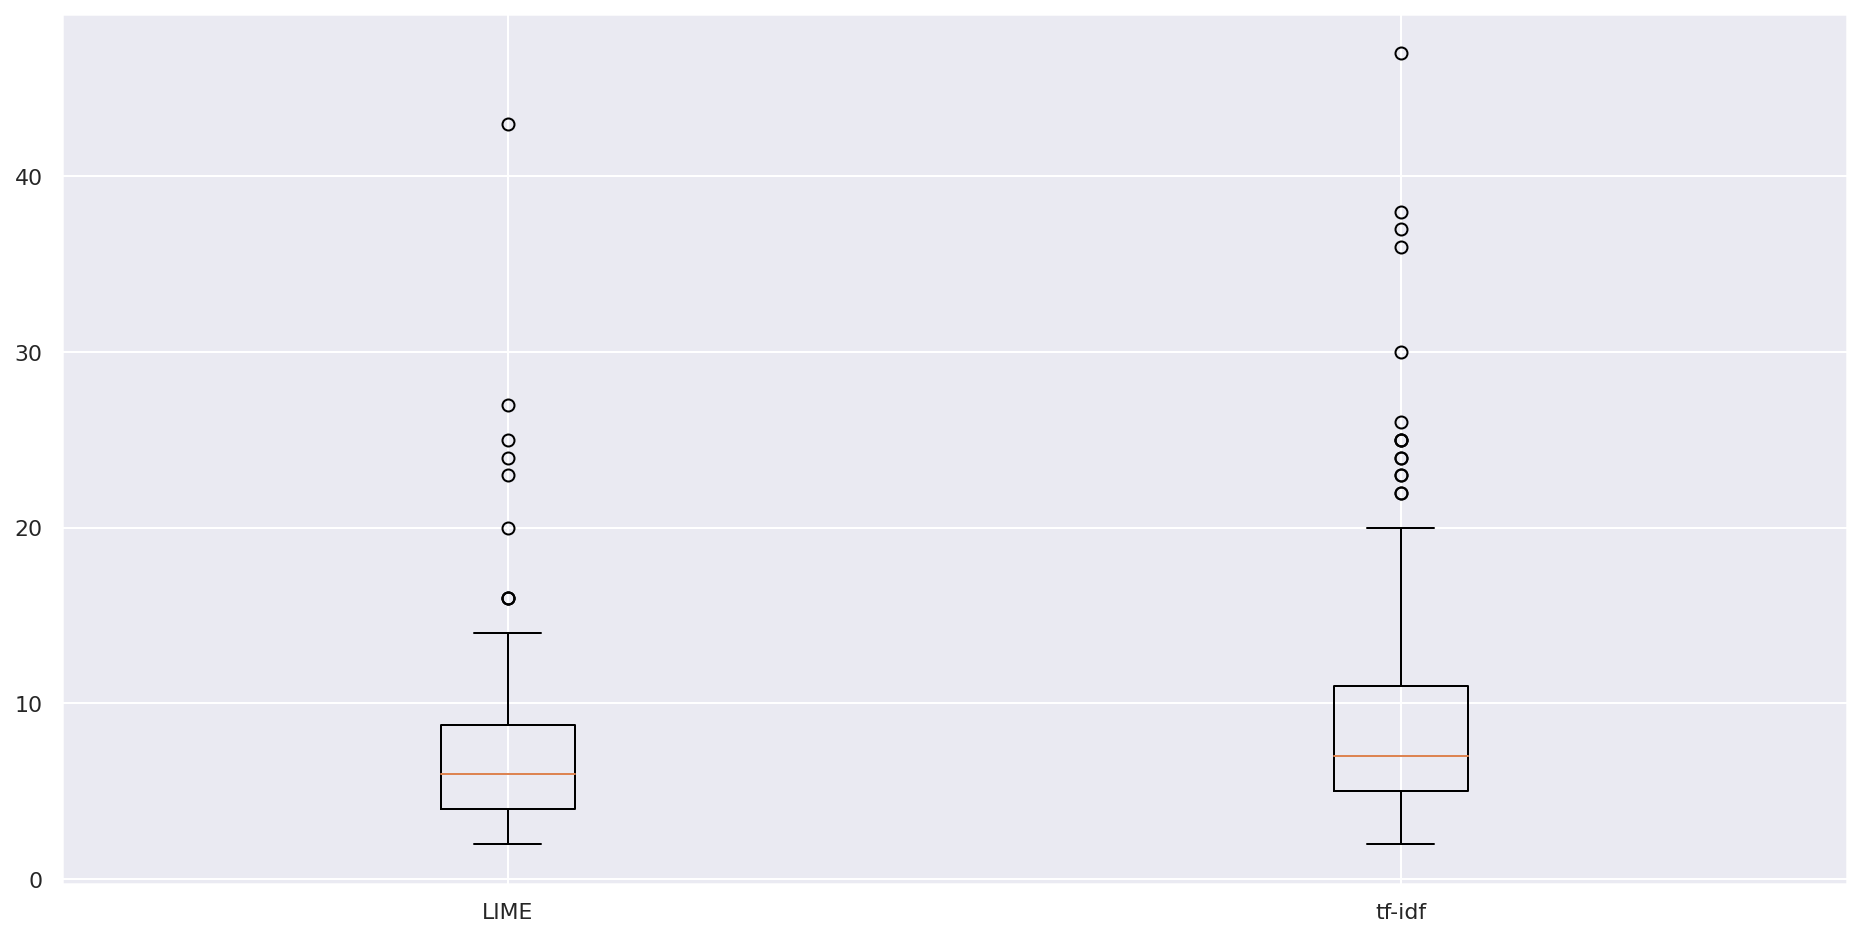

In [25]:
compare_boxplots(lime_k_recall, 
                 baseline_k_recall, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

Plot `k` values for LIME 

In [26]:
lime_k_recall_id = [entry['entity'] for entry in lime_metrics_list if entry['k_recall']]

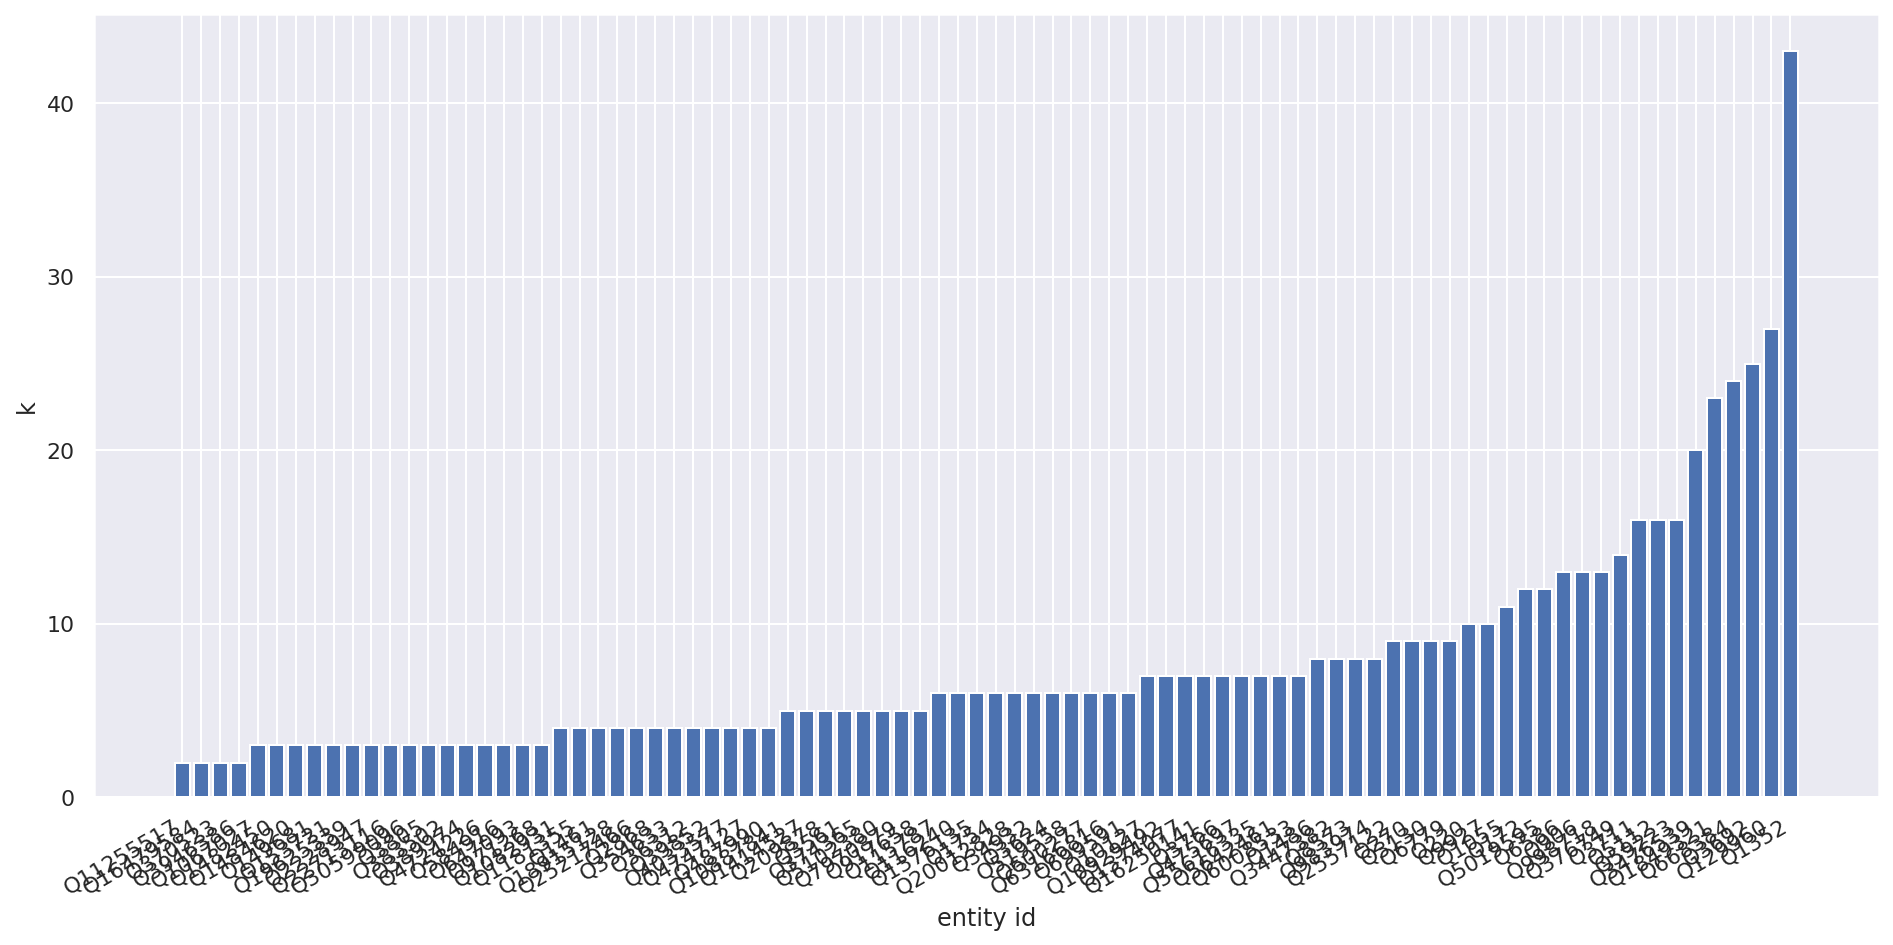

In [27]:
show_barplot(lime_k_recall_id, lime_k_recall, 'entity id', 'k', use_plotly)

**Metric 2**: maximum F1-score at k

In [28]:
ignore_ids = ['Q1484620', 'Q153721', 'Q383502', 'Q647093', 'Q971268', 'Q1067027', 'Q22713116']

In [29]:
min_k = sys.maxsize
min_name = None
for group_name, group_data in grouped_lime_df:
    num_terms = group_data.shape[0]
    if num_terms < min_k and group_name not in ignore_ids:
        min_name = group_name
        min_k = num_terms

In [30]:
min_k, min_name

(4, 'Q1181355')

In [31]:
grouped_lime_df.get_group(min_name)

,label,term,weight
493,Q1181355,aires,6.598487
494,Q1181355,asteroid,6.502141
495,Q1181355,buenos,6.325414
496,Q1181355,7850,3.737593


In [32]:
lime_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_f1score_avg = [sum(col)/len(col) for col in zip(*lime_max_f1score)]

baseline_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_f1score_avg = [sum(col)/len(col) for col in zip(*baseline_max_f1score)]

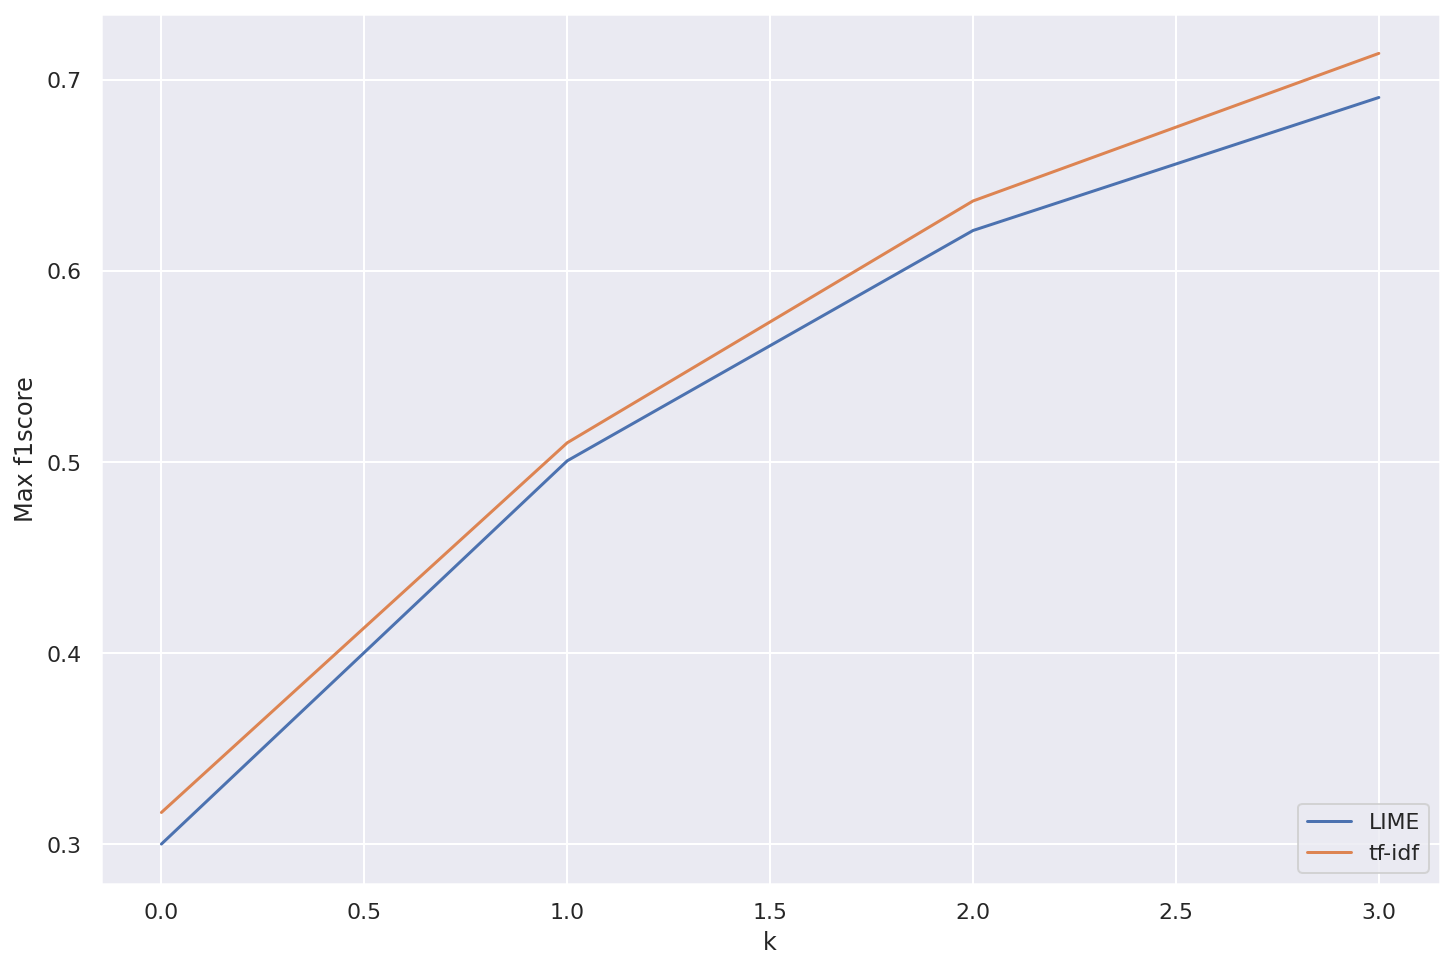

In [33]:
compare_lineplots(list(range(min_k)), 
                  lime_max_f1score_avg, 
                  baseline_max_f1score_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max f1score', 
                  use_plotly)

**Metric 3**: argmax f1-score

In [34]:
lime_argmax_f1score = [entry['argmax_f1score'] for entry in lime_metrics_list if entry['argmax_f1score'] is not None]
baseline_argmax_f1score = [entry['argmax_f1score'] for entry in baseline_metrics_list if entry['argmax_f1score'] is not None]

In [35]:
print(f'lime_argmax_f1score size: {len(lime_argmax_f1score)}')
print(f'baseline_argmax_f1score size: {len(baseline_argmax_f1score)}')

lime_argmax_f1score size: 195
baseline_argmax_f1score size: 195


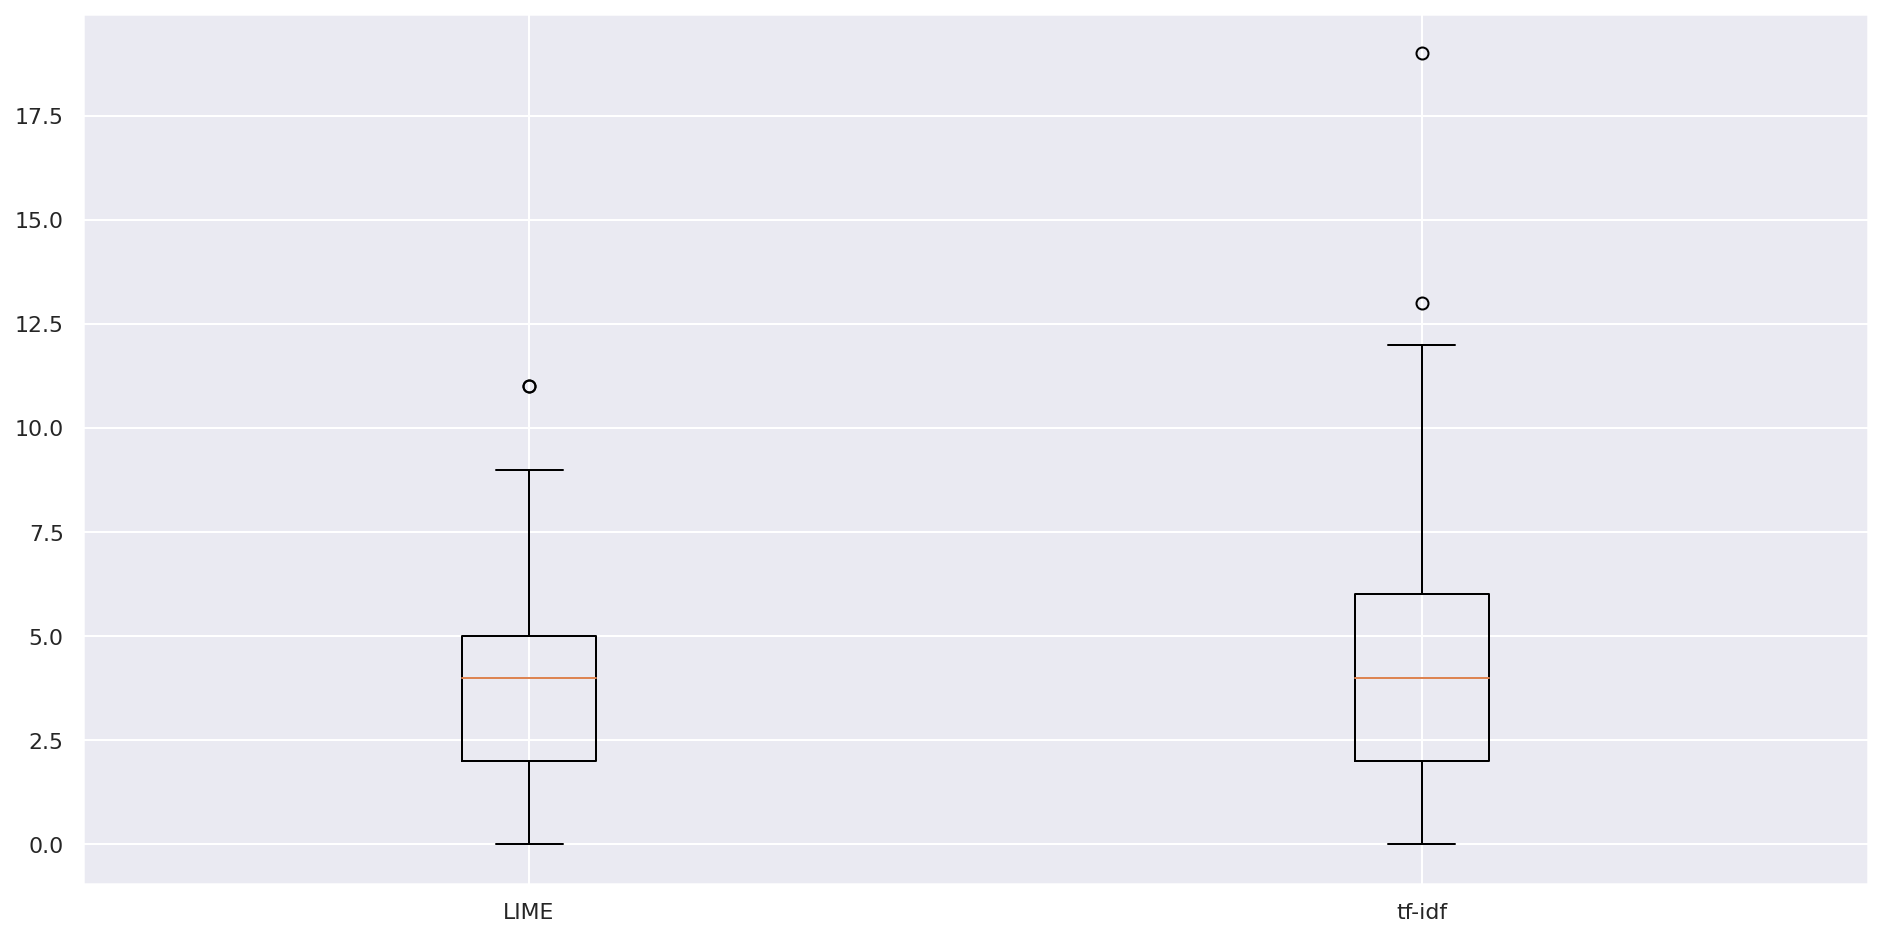

In [36]:
compare_boxplots(lime_argmax_f1score, 
                 baseline_argmax_f1score, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

**Metric 4**: maximum F2-score at k

In [37]:
lime_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_f2score_avg = [sum(col)/len(col) for col in zip(*lime_max_f2score)]

baseline_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_f2score_avg = [sum(col)/len(col) for col in zip(*baseline_max_f2score)]

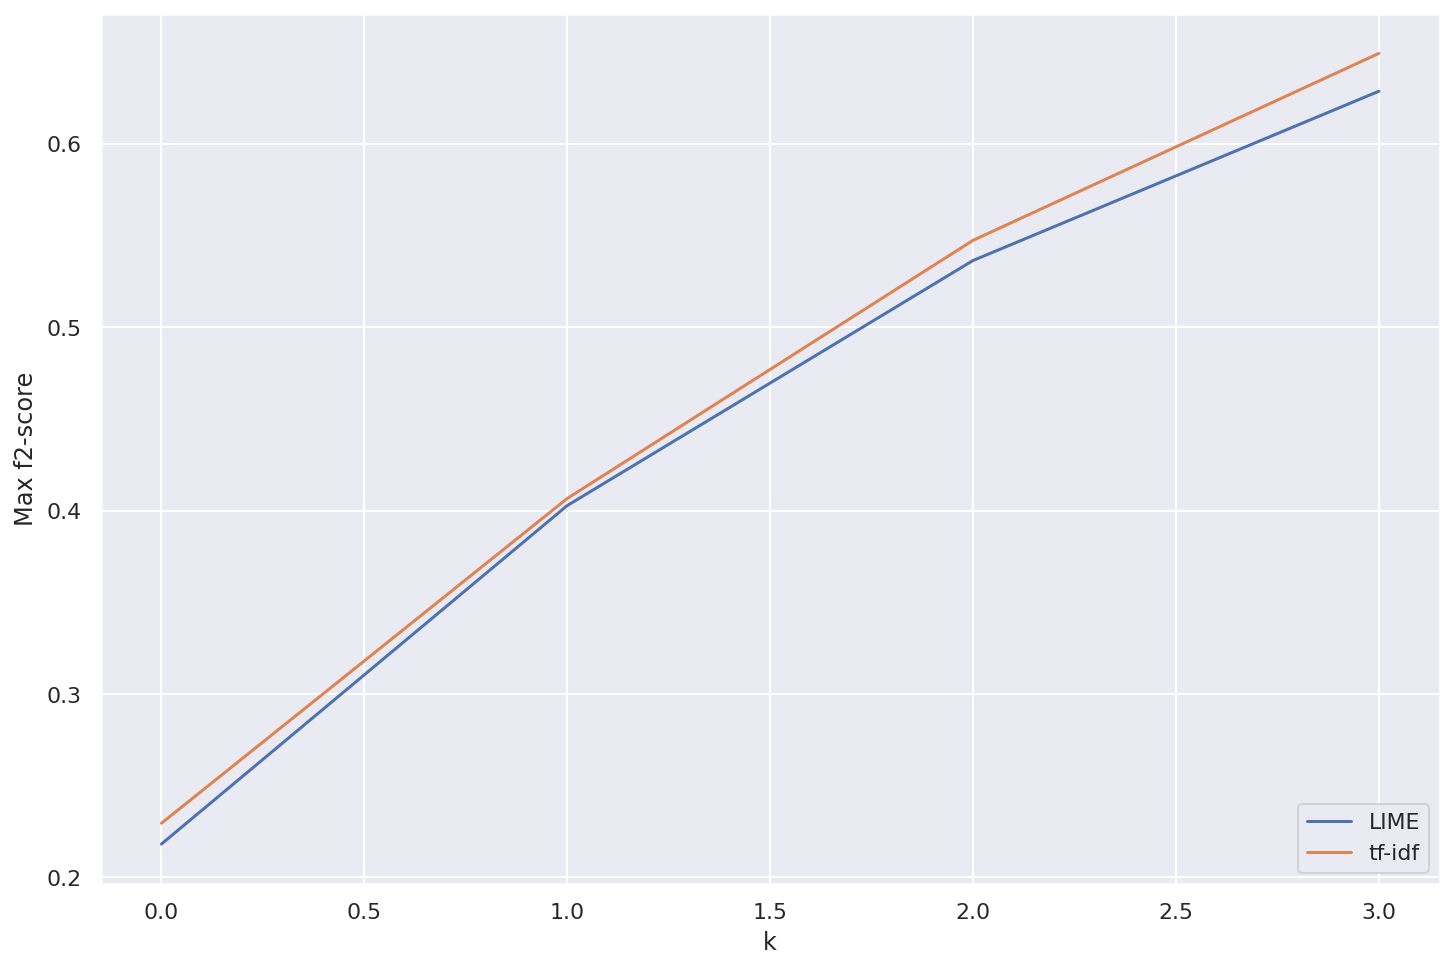

In [38]:
compare_lineplots(list(range(min_k)), 
                  lime_max_f2score_avg, 
                  baseline_max_f2score_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max f2-score', 
                  use_plotly)

**Metric 5**: maximum F0.5-score at k

In [39]:
lime_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_f05score_avg = [sum(col)/len(col) for col in zip(*lime_max_f05score)]

baseline_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_f05score_avg = [sum(col)/len(col) for col in zip(*baseline_max_f05score)]

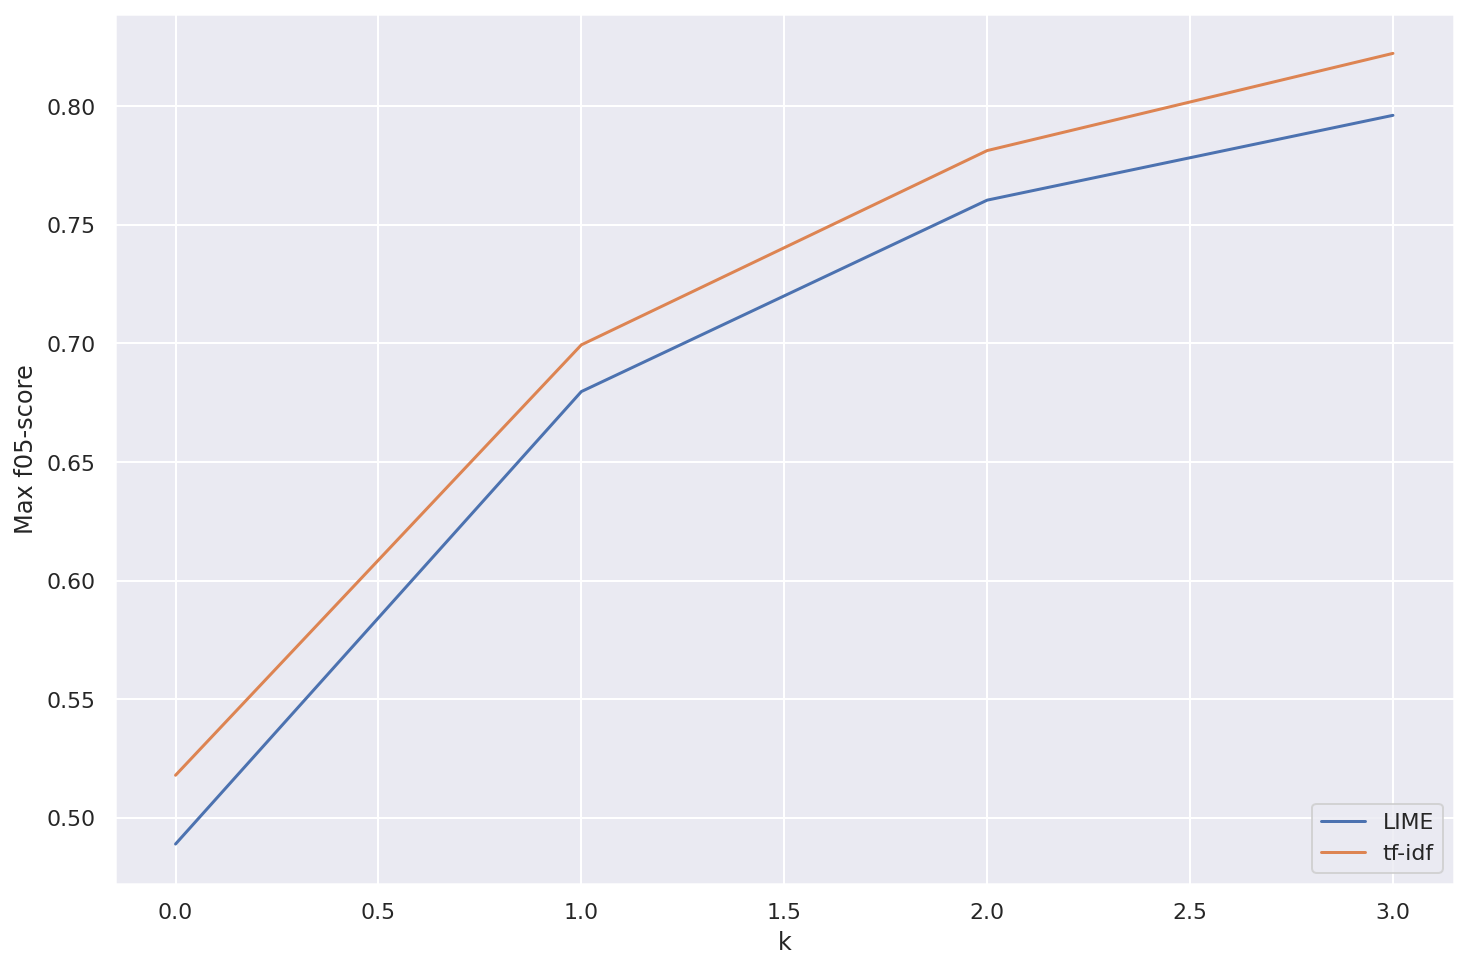

In [40]:
compare_lineplots(list(range(min_k)), 
                  lime_max_f05score_avg, 
                  baseline_max_f05score_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max f05-score', 
                  use_plotly)

**Metric 6**: `max(recall[i])` s.t `precision[i] > threshold` where `threshold = 0.9`

In [41]:
lime_max_recall = [entry['max_recall'] for entry in lime_metrics_list if entry['max_recall'] is not None]
baseline_max_recall = [entry['max_recall'] for entry in baseline_metrics_list if entry['max_recall'] is not None]

In [42]:
print(f'lime_max_recall size: {len(lime_max_recall)}')
print(f'baseline_max_recall size: {len(baseline_max_recall)}')

lime_max_recall size: 174
baseline_max_recall size: 185


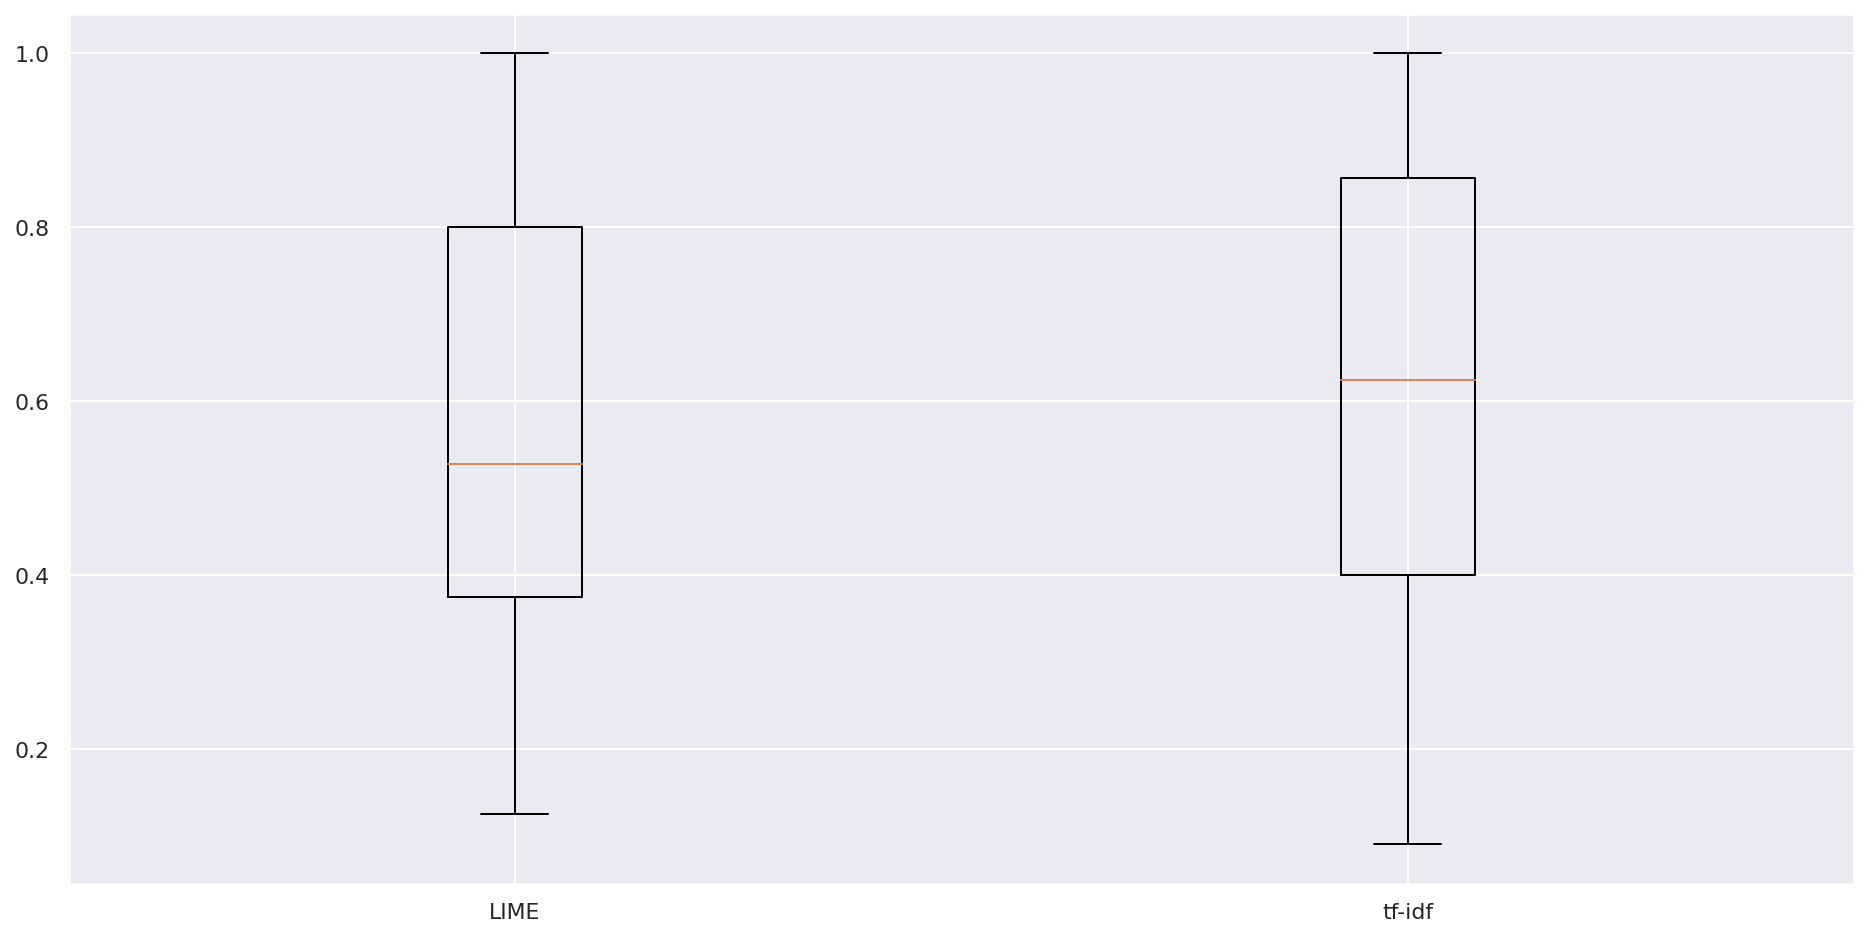

In [43]:
compare_boxplots(lime_max_recall, 
                 baseline_max_recall, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

**Metric 7**: `max(precision[i])` s.t `recall[i] > threshold` where `threshold = 0.9`

In [44]:
lime_max_precision = [entry['max_precision'] for entry in lime_metrics_list if entry['max_precision'] is not None]
baseline_max_precision = [entry['max_precision'] for entry in baseline_metrics_list if entry['max_precision'] is not None]

In [45]:
print(f'lime_max_precision size: {len(lime_max_precision)}')
print(f'baseline_max_precision size: {len(baseline_max_precision)}')

lime_max_precision size: 86
baseline_max_precision size: 132


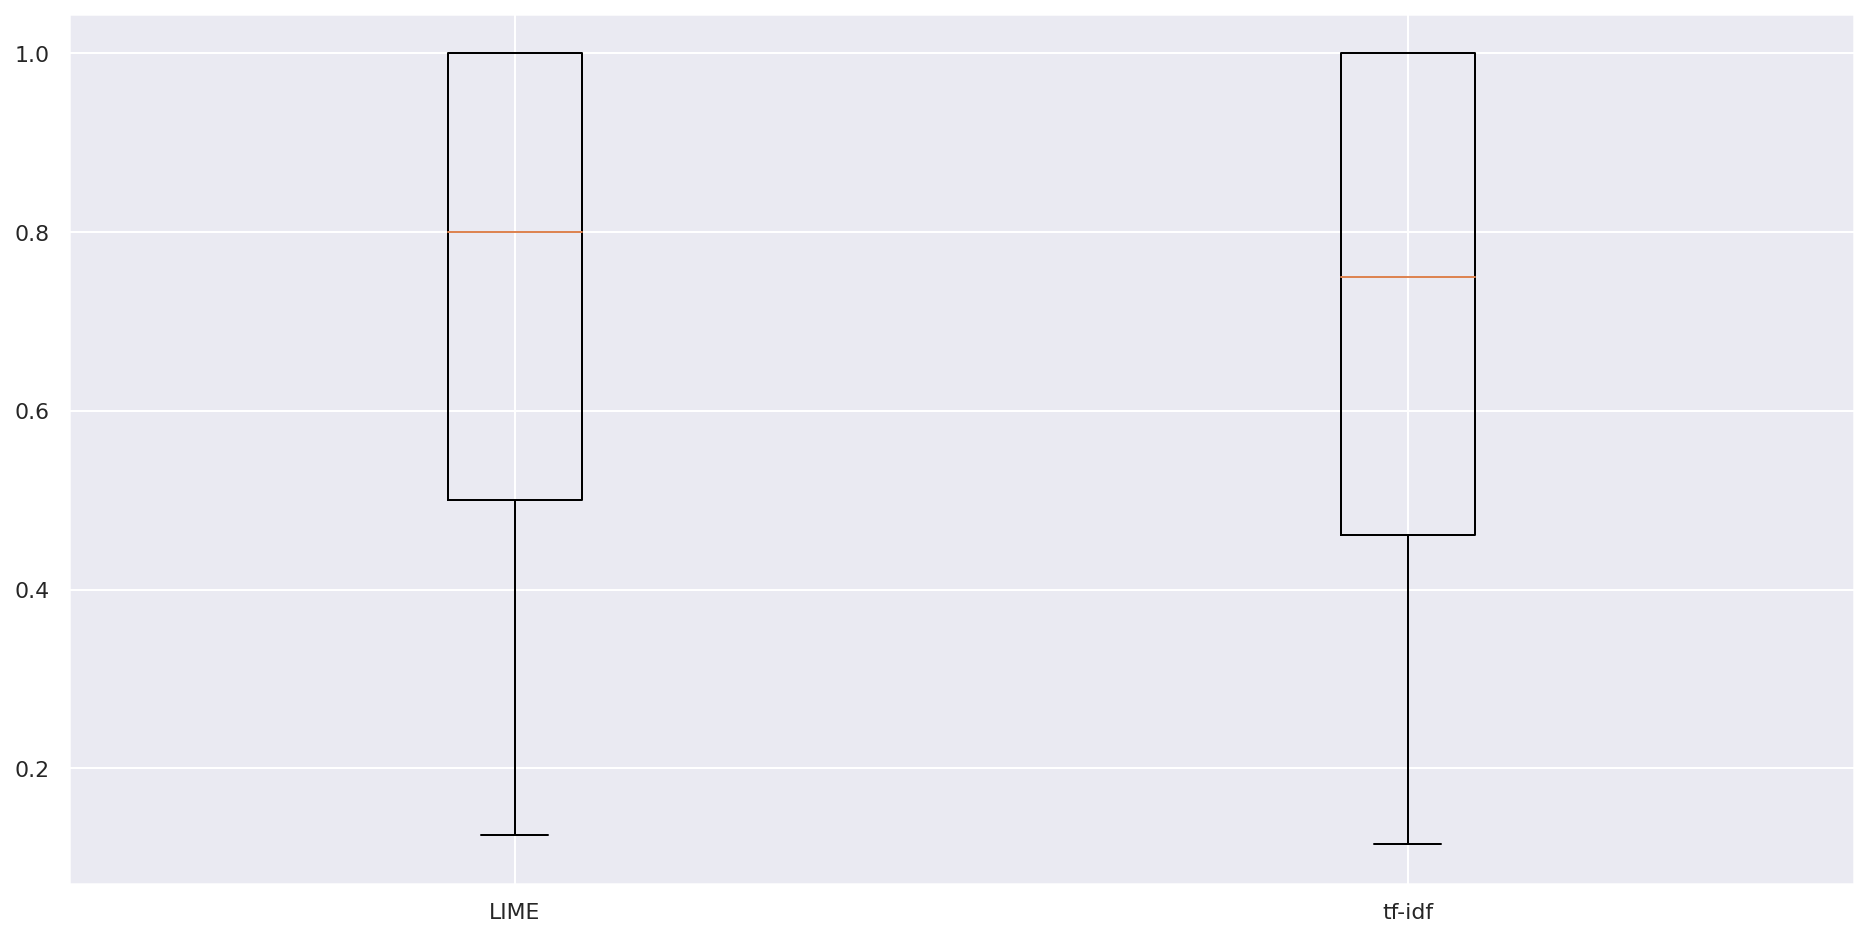

In [46]:
compare_boxplots(lime_max_precision, 
                 baseline_max_precision, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

**Metric 8**: maximum recall at k

In [47]:
lime_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*lime_max_recall_at_k)]

baseline_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*baseline_max_recall_at_k)]

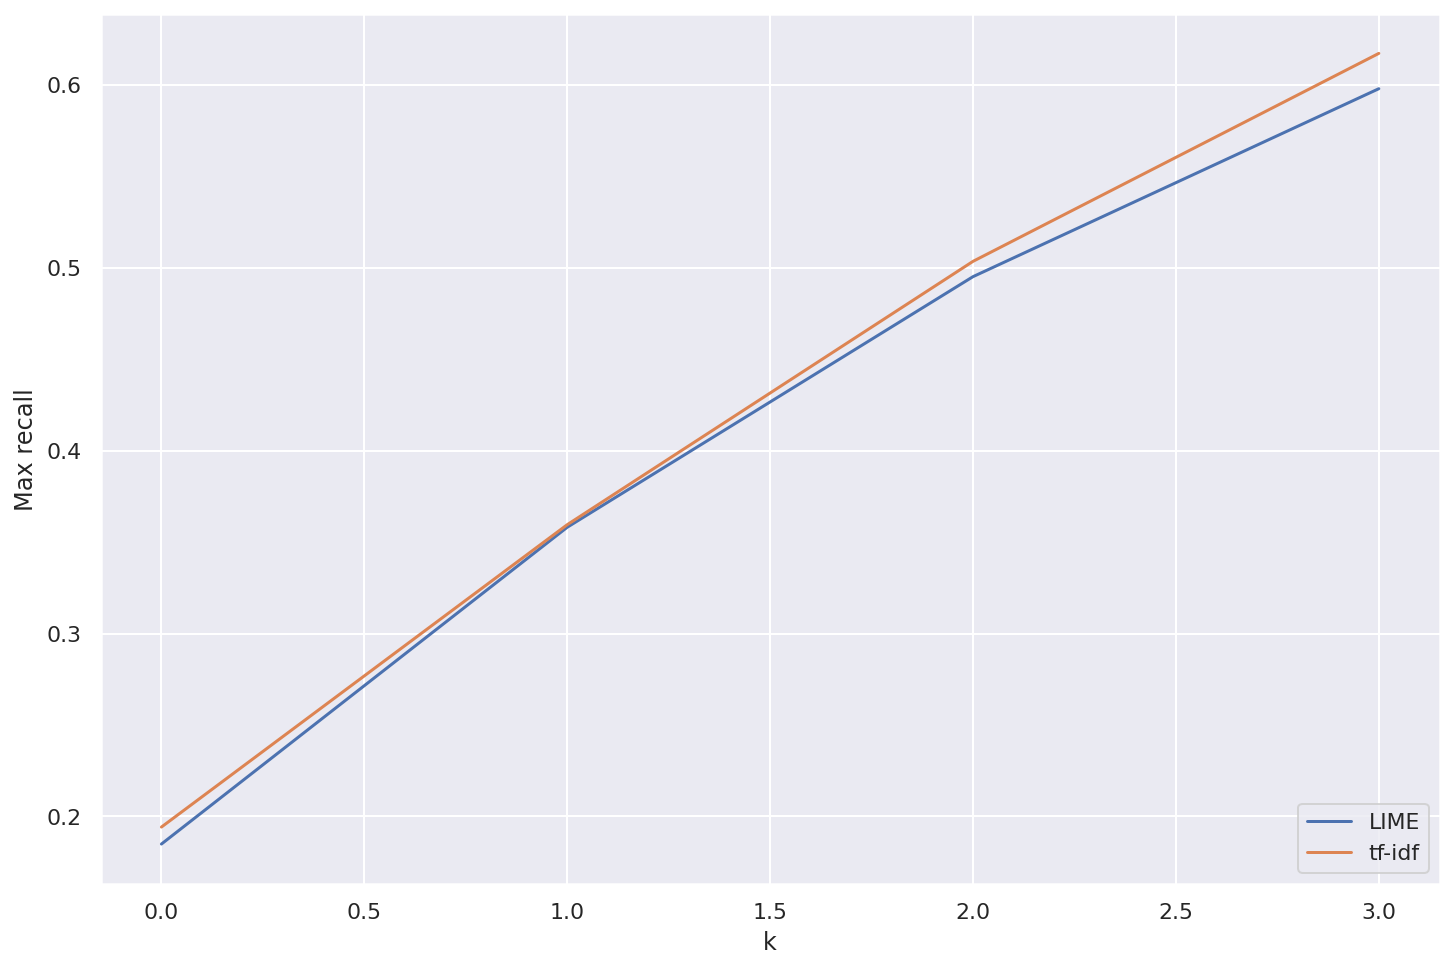

In [48]:
compare_lineplots(list(range(min_k)), 
                  lime_max_recall_at_k_avg, 
                  baseline_max_recall_at_k_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max recall', 
                  use_plotly)

**Metric 9**: maximum precision at k

In [49]:
lime_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*lime_max_precision_at_k)]

baseline_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*baseline_max_precision_at_k)]

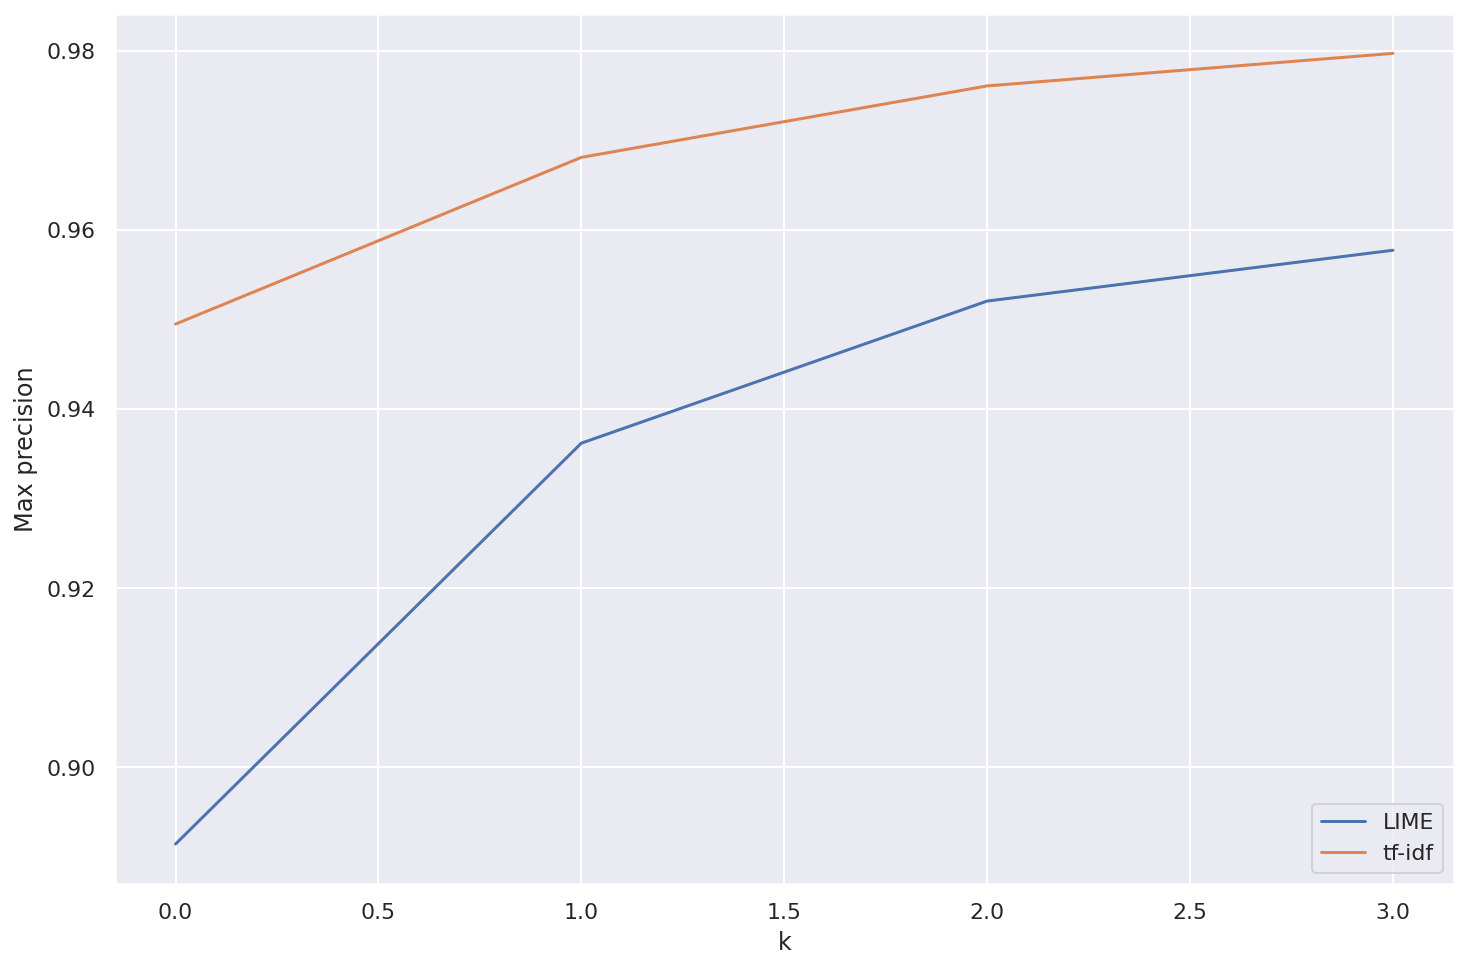

In [50]:
compare_lineplots(list(range(min_k)), 
                  lime_max_precision_at_k_avg, 
                  baseline_max_precision_at_k_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max precision', 
                  use_plotly)

---

## Write top N terms to file

In [51]:
filename = f'top_n_wikidata_tfidf_{version}.xlsx'
filepath = os.path.join(root_dir, data_dir, rank_dir, filename)

In [52]:
top_n = 30

In [53]:
from training import TrainingCorpus

In [54]:
with pd.ExcelWriter(filepath) as writer:
    for group_name, group_data in grouped_lime_df:
        num_terms = min(group_data['term'].shape[0], top_n)
        lime_terms = group_data['term'].values[:num_terms]
        baseline_terms = grouped_baseline_df.get_group(group_name)['term'][:num_terms]
        target = ' '.join(TrainingCorpus.tokenize(gt_dict[group_name]))

        df = pd.DataFrame({'lime_term': lime_terms,
                           'baseline_term': baseline_terms,
                           'target': target})
        df.to_excel(writer,
                    sheet_name=group_name, 
                    index=False)   